In [1]:
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd
import numpy as np
from models import KMeansPartitioner
from sklearn import preprocessing
from pyFTS.partitioners import Grid, Util as pUtil
from pyFTS.models import hofts

from models import sthofts
import matplotlib.pyplot as plt
import datetime
import dispy
import math
from sklearn.metrics import mean_squared_error

In [2]:
!pip install -U git+https://github.com/petroniocandido/pyFTS

  Cloning https://github.com/petroniocandido/pyFTS to /private/var/folders/13/t7d8w0nd0hv6w9_p2rntvym00000gr/T/pip-req-build-q6ysgwex
  Running setup.py bdist_wheel for pyFTS ... done
  Stored in directory: /private/var/folders/13/t7d8w0nd0hv6w9_p2rntvym00000gr/T/pip-ephem-wheel-cache-3inasz9v/wheels/84/d7/1e/a333c7128f25b347640740859808db094c4478e98663cd2297
Successfully built pyFTS
  Found existing installation: pyFTS 1.2.2
    Uninstalling pyFTS-1.2.2:
      Successfully uninstalled pyFTS-1.2.2


## Auxiliary Functions

In [2]:
def normalize(df):
    mindf = df.min()
    maxdf = df.max()
    return (df-mindf)/(maxdf-mindf)

In [3]:
def split_data(df, df_clean, df_residual, interval):
    sample_df = df.loc[interval]
    residual_sample_df = df_residual.loc[interval]
    clean_sample_df = df_clean.loc[interval]

    norm_residual_sample_df = normalize(residual_sample_df)
    norm_clean_sample_df = normalize(clean_sample_df)


    week = (sample_df.index.day - 1) // 7 + 1

    # PARA OS TESTES:
    # 2 SEMANAS PARA TREINAMENTO
    train_df = sample_df.loc[week <= 2]
    train_residual_df = norm_residual_sample_df.loc[week <= 2]
    train_clean_df = norm_clean_sample_df.loc[week <= 2]

    # 1 SEMANA PARA VALIDACAO
    validation_df = sample_df.loc[week == 3]
    validation_residual_df = norm_residual_sample_df.loc[week == 3]
    validation_clean_df = norm_clean_sample_df.loc[week == 3]

    # 1 SEMANA PARA TESTES
    test_df = sample_df.loc[week > 3]
    test_residual_df = norm_residual_sample_df.loc[week > 3]
    test_clean_df = norm_clean_sample_df.loc[week > 3]
    
    return (train_df, train_clean_df, train_residual_df, validation_df, validation_clean_df, validation_residual_df, test_df, test_clean_df, test_residual_df)

In [4]:
def start_dispy_cluster(method, nodes):
    import dispy, dispy.httpd, logging

    cluster = dispy.JobCluster(method, nodes=nodes, loglevel=logging.DEBUG, ping_interval=1000)

    http_server = dispy.httpd.DispyHTTPServer(cluster)

    return cluster, http_server

In [5]:
def stop_dispy_cluster(cluster, http_server):
    cluster.wait()  # wait for all jobs to finish

    cluster.print_status()

    http_server.shutdown()  # this waits until browser gets all updates
    cluster.close()

## Loading Data

In [4]:
df = pd.read_pickle("df_oahu.pkl")
df_ssa_clean = pd.read_pickle("df_ssa_clean.pkl")
df_ssa_residual = pd.read_pickle("df_ssa_residual.pkl")

In [5]:
df.drop(columns=['AP_1', 'AP_7'], inplace=True)
df_ssa_clean.drop(columns=['AP_1', 'AP_7'], inplace=True)
df_ssa_residual.drop(columns=['AP_1', 'AP_7'], inplace=True)

Entire data split by season 

In [6]:
interval = ((df.index >= '2010-11') & (df.index <= '2010-12'))
(train_df, train_clean_df, train_residual_df, 
 validation_df, validation_clean_df, validation_residual_df, 
 test_df, test_clean_df, test_residual_df) = split_data(df, df_ssa_clean, df_ssa_residual, interval)

i) Winter (Dec-Jan-Feb), ii) Spring (Mar-Apr-May), iii)
Summer (Jun-Jul-Aug) and iv) Autumn (Sep-Oct-Nov).

In [9]:
summer_interval = ((df.index >= '2010-06') & (df.index <= '2010-09'))
(summer_train_df, summer_train_clean_df, summer_train_residual_df, 
 summer_validation_df, summer_validation_clean_df, summer_validation_residual_df, 
 summer_test_df, summer_test_clean_df, summer_test_residual_df) = split_data(df, df_ssa_clean, df_ssa_residual, summer_interval)

In [10]:
autumn_interval = ((df.index >= '2010-09') & (df.index <= '2010-12'))
(autumn_train_df, autumn_train_clean_df, autumn_train_residual_df, 
 autumn_validation_df, autumn_validation_clean_df, autumn_validation_residual_df, 
 autumn_test_df, autumn_test_clean_df, autumn_test_residual_df) = split_data(df, df_ssa_clean, df_ssa_residual, autumn_interval)

In [11]:
winter_interval = ((df.index >= '2010-12') & (df.index <= '2011-03'))
(winter_train_df, winter_train_clean_df, winter_train_residual_df, 
winter_validation_df, winter_validation_clean_df, winter_validation_residual_df, 
winter_test_df, winter_test_clean_df, winter_test_residual_df) = split_data(df, df_ssa_clean, df_ssa_residual, winter_interval)

In [12]:
spring_interval = ((df.index >= '2011-03') & (df.index <= '2011-06'))
(spring_train_df, spring_train_clean_df, spring_train_residual_df, 
 spring_validation_df, spring_validation_clean_df, spring_validation_residual_df, 
 spring_test_df, spring_test_clean_df, spring_test_residual_df) = split_data(df, df_ssa_clean, df_ssa_residual, spring_interval)

In [7]:
target_station = 'DHHL_3'

In [8]:
#All neighbor stations with residual correlation greater than .90
neighbor_stations_90 = ['DHHL_3',  'DHHL_4','DHHL_5','DHHL_10','DHHL_11','DHHL_9','DHHL_2', 'DHHL_6','DHHL_7','DHHL_8']


## Parameter Tuning

## ARIMA

In [14]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX    
import warnings
warnings.filterwarnings("ignore")

/Users/cseveriano/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [35]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, validation, arima_order):

    whole_data = train.append(validation)
    test_data = validation
    
    training_mod = SARIMAX(whole_data.values, order=arima_order, seasonal_order=(0,0,0,0))
    training_res = training_mod.fit()
    
    mod = SARIMAX(whole_data.values, order=arima_order, seasonal_order=(0,0,0,0))
    res = mod.filter(training_res.params)
    
    insample = res.predict()
    wlen = len(whole_data)
    tlen = len(test_data)

    predictions = insample[wlen-tlen:]    
    
    error = math.sqrt(mean_squared_error(validation, predictions))
    return error


In [31]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(test_name, train_df, validation_df, p_values, d_values, q_values):
    arima_results = pd.DataFrame(columns=['Order','RMSE'])
    best_score, best_cfg = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                print('Testing ARIMA%s ' % str(order))
                #try:
                rmse = evaluate_arima_model(train_df, validation_df, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order

                res = {'Order' : str(order) ,'RMSE' : rmse}
                print('ARIMA%s RMSE=%.3f' % (order,rmse))
                arima_results = arima_results.append(res, ignore_index=True)
                arima_results.to_csv(test_name+".csv")
                #except:
                print('Invalid model%s ' % str(order))
                continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [16]:
# evaluate combinations of p, d and q values for an ARIMA model
def distributed_arima_evaluate_models(eval_method, test_name, train_df, validation_df, p_values, d_values, q_values):

    best_score, best_cfg = float("inf"), None
    method = eval_method
    nodes=['192.168.1.3']
    cluster, http_server = start_dispy_cluster(method, nodes)
    jobs = []
    job_count = 1

    arima_results = pd.DataFrame(columns=['Order','RMSE'])

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                print('Testing ARIMA%s ' % str(order))
                job = cluster.submit(train_df, validation_df, order)
                job.id = job_count  # associate an ID to identify jobs (if needed later)
                jobs.append(job)
                job_count += 1
                
    for job in jobs:
        print("[{0: %H:%M:%S}] Processing batch ".format(datetime.datetime.now()) + str(job.id))
        rmse = job()
        if job.status == dispy.DispyJob.Finished and rmse is not None:
            if rmse < best_score:
                best_score, best_cfg = rmse, order

            res = {'Order' : str(order) ,'RMSE' : rmse}
            print('ARIMA%s RMSE=%.3f' % (order,rmse))
            arima_results = arima_results.append(res, ignore_index=True)
            arima_results.to_csv(test_name+".csv")
        else:
            print(job.exception)
            print(job.stdout)

        print("[{0: %H:%M:%S}] Finished batch ".format(datetime.datetime.now()) + str(job.id))

    print("[{0: %H:%M:%S}] Distributed Tuning Finished".format(datetime.datetime.now()))            
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    stop_dispy_cluster(cluster, http_server)

In [18]:
# evaluate parameters
p_values = [0,1,2]
d_values = [0,1]
q_values = [0,1,2]
#warnings.filterwarnings("ignore")
distributed_arima_evaluate_models(evaluate_arima_model,"arima-oahu-clean",train_clean_df[target_station], validation_clean_df[target_station], p_values, d_values, q_values)
distributed_arima_evaluate_models(evaluate_arima_model,"arima-oahu-residual",train_residual_df[target_station], validation_residual_df[target_station], p_values, d_values, q_values)

2018-06-13 16:11:47 pycos - version 4.6.5 with kqueue I/O notifier
2018-06-13 16:11:47 dispy - dispy client version: 4.8.7
2018-06-13 16:11:48 dispy - Storing fault recovery information in "_dispy_20180613161147"
2018-06-13 16:11:48 dispy - dispy client at 192.168.1.3:51347
2018-06-13 16:11:48 dispy - Started HTTP server at ('0.0.0.0', 8181)
Testing ARIMA(0, 0, 0) 
Testing ARIMA(0, 0, 1) 
Testing ARIMA(0, 0, 2) 
Testing ARIMA(0, 1, 0) 
Testing ARIMA(0, 1, 1) 
Testing ARIMA(0, 1, 2) 
Testing ARIMA(1, 0, 0) 
Testing ARIMA(1, 0, 1) 
Testing ARIMA(1, 0, 2) 
Testing ARIMA(1, 1, 0) 
Testing ARIMA(1, 1, 1) 
Testing ARIMA(1, 1, 2) 
Testing ARIMA(2, 0, 0) 
Testing ARIMA(2, 0, 1) 
Testing ARIMA(2, 0, 2) 
Testing ARIMA(2, 1, 0) 
Testing ARIMA(2, 1, 1) 
Testing ARIMA(2, 1, 2) 
[ 16:11:48] Processing batch 1
2018-06-13 16:11:48 dispy - Discovered 192.168.1.3:51348 (minds-imac-1.local) with 3 cpus
2018-06-13 16:11:48 dispy - Running job 112091245808 on 192.168.1.3
2018-06-13 16:11:48 dispy - Running

Testar outros datasets

In [125]:
evaluate_models("arima-spring-clean",spring_train_clean_df[target_station], spring_validation_clean_df[target_station], p_values, d_values, q_values)
evaluate_models("arima-autumn-clean",autumn_train_clean_df[target_station], autumn_validation_clean_df[target_station], p_values, d_values, q_values)
evaluate_models("arima-winter-clean",winter_train_clean_df[target_station], winter_validation_clean_df[target_station], p_values, d_values, q_values)

evaluate_models("arima-summer-residual",summer_train_residual_df[target_station], summer_validation_residual_df[target_station], p_values, d_values, q_values)
evaluate_models("arima-spring-residual",spring_train_residual_df[target_station], spring_validation_residual_df[target_station], p_values, d_values, q_values)
evaluate_models("arima-autumn-residual",autumn_train_residual_df[target_station], autumn_validation_residual_df[target_station], p_values, d_values, q_values)
evaluate_models("arima-winter-residual",winter_train_residual_df[target_station], winter_validation_residual_df[target_station], p_values, d_values, q_values)


Testing ARIMA(0, 0, 0) 
ARIMA(0, 0, 0) RMSE=0.279
Testing ARIMA(0, 0, 1) 
ARIMA(0, 0, 1) RMSE=0.140
Testing ARIMA(0, 0, 2) 
Invalid model(0, 0, 2) 
Testing ARIMA(0, 1, 0) 
ARIMA(0, 1, 0) RMSE=0.034
Testing ARIMA(0, 1, 1) 
ARIMA(0, 1, 1) RMSE=0.019
Testing ARIMA(0, 1, 2) 
Invalid model(0, 1, 2) 
Testing ARIMA(1, 0, 0) 
ARIMA(1, 0, 0) RMSE=0.034
Testing ARIMA(1, 0, 1) 
Invalid model(1, 0, 1) 
Testing ARIMA(1, 0, 2) 
Invalid model(1, 0, 2) 
Testing ARIMA(1, 1, 0) 
ARIMA(1, 1, 0) RMSE=0.011
Testing ARIMA(1, 1, 1) 
ARIMA(1, 1, 1) RMSE=0.009
Testing ARIMA(1, 1, 2) 
ARIMA(1, 1, 2) RMSE=0.010
Testing ARIMA(2, 0, 0) 
Invalid model(2, 0, 0) 
Testing ARIMA(2, 0, 1) 
ARIMA(2, 0, 1) RMSE=0.009
Testing ARIMA(2, 0, 2) 
Invalid model(2, 0, 2) 
Testing ARIMA(2, 1, 0) 
ARIMA(2, 1, 0) RMSE=0.010
Testing ARIMA(2, 1, 1) 
ARIMA(2, 1, 1) RMSE=0.010
Testing ARIMA(2, 1, 2) 
ARIMA(2, 1, 2) RMSE=0.010
Best ARIMA(2, 0, 1) RMSE=0.009


NameError: name 'autumn_train_clean_df' is not defined

In [ ]:
distributed_arima_evaluate_models(evaluate_arima_model,"arima-spring-clean",spring_train_clean_df[target_station], spring_validation_clean_df[target_station], p_values, d_values, q_values)
distributed_arima_evaluate_models(evaluate_arima_model,"arima-autumn-clean",autumn_train_clean_df[target_station], autumn_validation_clean_df[target_station], p_values, d_values, q_values)
distributed_arima_evaluate_models(evaluate_arima_model,"arima-winter-clean",winter_train_clean_df[target_station], winter_validation_clean_df[target_station], p_values, d_values, q_values)

distributed_arima_evaluate_models(evaluate_arima_model,"arima-summer-residual",summer_train_residual_df[target_station], summer_validation_residual_df[target_station], p_values, d_values, q_values)
distributed_arima_evaluate_models(evaluate_arima_model,"arima-spring-residual",spring_train_residual_df[target_station], spring_validation_residual_df[target_station], p_values, d_values, q_values)
distributed_arima_evaluate_models(evaluate_arima_model,"arima-autumn-residual",autumn_train_residual_df[target_station], autumn_validation_residual_df[target_station], p_values, d_values, q_values)
distributed_arima_evaluate_models(evaluate_arima_model,"arima-winter-residual",winter_train_residual_df[target_station], winter_validation_residual_df[target_station], p_values, d_values, q_values)


2018-06-13 12:15:33 dispy - Started HTTP server at ('0.0.0.0', 8181)
Testing ARIMA(0, 0, 0) 
2018-06-13 12:15:33 dispy - Running job 120614657264 on 192.168.1.3
Testing ARIMA(0, 0, 1) 
Testing ARIMA(0, 0, 2) 
2018-06-13 12:15:33 dispy - Running job 120614656664 on 192.168.1.3
Testing ARIMA(0, 1, 0) 
Testing ARIMA(0, 1, 1) 
2018-06-13 12:15:33 dispy - Running job 120614656544 on 192.168.1.3
Testing ARIMA(0, 1, 2) 
2018-06-13 12:15:33 dispy - Running job 1 / 120614657264 on 192.168.1.3 (busy: 3 / 3)
Testing ARIMA(1, 0, 0) 
Testing ARIMA(1, 0, 1) 
2018-06-13 12:15:33 dispy - Running job 2 / 120614656664 on 192.168.1.3 (busy: 3 / 3)
Testing ARIMA(1, 0, 2) 
Testing ARIMA(1, 1, 0) 
Testing ARIMA(1, 1, 1) 
Testing ARIMA(1, 1, 2) 
2018-06-13 12:15:33 dispy - Running job 3 / 120614656544 on 192.168.1.3 (busy: 3 / 3)
Testing ARIMA(2, 0, 0) 
Testing ARIMA(2, 0, 1) 
Testing ARIMA(2, 0, 2) 
Testing ARIMA(2, 1, 0) 
Testing ARIMA(2, 1, 1) 
Testing ARIMA(2, 1, 2) 
[ 12:15:33] Processing batch 1
2018-0

## SARIMA

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

/Users/cseveriano/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [23]:
# evaluate an ARIMA model for a given order (p,d,q)
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
from sklearn.metrics import mean_squared_error

def evaluate_sarima_model(train, validation, arima_order, sarima_order):
    
    whole_data = train.append(validation)
    test_data = validation
    
    training_mod = SARIMAX(whole_data.values, order=arima_order, seasonal_order=sarima_order, disp=True)
    training_res = training_mod.fit()
    
    mod = SARIMAX(whole_data.values, order=arima_order, seasonal_order=sarima_order)
    res = mod.filter(training_res.params)
    
    insample = res.predict()
    wlen = len(whole_data)
    tlen = len(test_data)

    predictions = insample[wlen-tlen:]    
    # calculate out of sample error
    error = math.sqrt(mean_squared_error(validation, predictions))
    return error

In [14]:
# evaluate combinations of p, d and q values for an ARIMA model
import sys
def evaluate_sarima_models(test_name, train_df, validation_df, parameters_list, period_length):

    sarima_results = pd.DataFrame(columns=['Order','RMSE'])
    best_score, best_cfg = float("inf"), None

    for param in parameters_list:
        arima_order = (param[0],param[1],param[2])
        sarima_order = (param[3],param[4],param[5],period_length)
        print('Testing SARIMA%s %s ' % (str(arima_order),str(sarima_order)))
        try:
            rmse = evaluate_sarima_model(train_df, validation_df, arima_order, sarima_order)
            if rmse < best_score:
                best_score, best_cfg = rmse, param

            res = {'Order' : str(param) ,'RMSE' : rmse}
            print('SARIMA%s %s RMSE=%.3f' % (str(arima_order),str(sarima_order),rmse))
            sarima_results = sarima_results.append(res, ignore_index=True)
            sarima_results.to_csv(test_name+".csv")
        except:
            print(sys.exc_info())
            print('Invalid model%s %s ' % (str(arima_order),str(sarima_order)))
            continue
    print('Best SARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [41]:
# evaluate combinations of p, d and q values for an ARIMA model
def distributed_sarima_evaluate_models(eval_method, test_name, train_df, validation_df, parameters_list, period_length):

    best_score, best_cfg = float("inf"), None
    method = eval_method
    nodes=['192.168.1.3']
    cluster, http_server = start_dispy_cluster(method, nodes)
    jobs = []
    job_count = 1

    sarima_results = pd.DataFrame(columns=['Order','RMSE'])

    for param in parameters_list:
        arima_order = (param[0],param[1],param[2])
        sarima_order = (param[3],param[4],param[5],period_length)
        
        print('Testing SARIMA%s %s ' % (str(arima_order),str(sarima_order)))
        job = cluster.submit(train_df, validation_df, arima_order,sarima_order)
        job.id = job_count  # associate an ID to identify jobs (if needed later)
        jobs.append(job)
        job_count += 1
                
    for job in jobs:
        print("[{0: %H:%M:%S}] Processing batch ".format(datetime.datetime.now()) + str(job.id))
        rmse = job()
        if job.status == dispy.DispyJob.Finished and rmse is not None:
            if rmse < best_score:
                best_score, best_cfg = rmse, param

            res = {'Order' : str(param) ,'RMSE' : rmse}
            print('SARIMA%s %s RMSE=%.3f' % (str(arima_order),str(sarima_order),rmse))
            sarima_results = sarima_results.append(res, ignore_index=True)
            sarima_results.to_csv(test_name+".csv")
        else:
            print(job.exception)
            print(job.stdout)

        print("[{0: %H:%M:%S}] Finished batch ".format(datetime.datetime.now()) + str(job.id))

    print("[{0: %H:%M:%S}] Distributed Tuning Finished".format(datetime.datetime.now()))            
    print('Best SARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
    stop_dispy_cluster(cluster, http_server)

2018-06-13 16:49:13 dispy - Removing node 192.168.1.3
2018-06-13 16:49:23 dispy - Discovered 192.168.1.3:51348 (minds-imac-1.local) with 3 cpus


In [ ]:
p_values = [0,1,2]
d_values = [0,1]
q_values = [0,1,2]
P_values = [0,1]
D_Values = [0,1]
Q_Values = [0,1]

parameters = product(p_values, d_values, q_values, P_values, D_Values, Q_Values)
parameters_list = list(parameters)
period_length = 61 #de 5:00 as 20:00
distributed_sarima_evaluate_models(evaluate_sarima_model, "dist-sarima-summer-clean",summer_train_clean_df[target_station], summer_validation_clean_df[target_station], parameters_list, period_length)

2018-06-13 16:50:33 dispy - Started HTTP server at ('0.0.0.0', 8181)
Testing SARIMA(0, 0, 0) (0, 0, 0, 61) 
2018-06-13 16:50:33 dispy - Running job 112204522744 on 192.168.1.3
Testing SARIMA(0, 0, 0) (0, 0, 1, 61) 
Testing SARIMA(0, 0, 0) (0, 1, 0, 61) 
2018-06-13 16:50:33 dispy - Running job 112204523104 on 192.168.1.3
Testing SARIMA(0, 0, 0) (0, 1, 1, 61) 
Testing SARIMA(0, 0, 0) (1, 0, 0, 61) 
2018-06-13 16:50:33 dispy - Running job 112204522984 on 192.168.1.3
Testing SARIMA(0, 0, 0) (1, 0, 1, 61) 
2018-06-13 16:50:33 dispy - Running job 1 / 112204522744 on 192.168.1.3 (busy: 3 / 3)
Testing SARIMA(0, 0, 0) (1, 1, 0, 61) 
Testing SARIMA(0, 0, 0) (1, 1, 1, 61) 
Testing SARIMA(0, 0, 1) (0, 0, 0, 61) 2018-06-13 16:50:33 dispy - Running job 2 / 112204523104 on 192.168.1.3 (busy: 3 / 3)

Testing SARIMA(0, 0, 1) (0, 0, 1, 61) 
Testing SARIMA(0, 0, 1) (0, 1, 0, 61) 
Testing SARIMA(0, 0, 1) (0, 1, 1, 61) 
Testing SARIMA(0, 0, 1) (1, 0, 0, 61) 
2018-06-13 16:50:33 dispy - Running job 3 / 1122

In [ ]:
evaluate_sarima_models("sarima-spring-clean",spring_train_clean_df[target_station], spring_validation_clean_df[target_station], parameters_list, period_length)
evaluate_sarima_models("sarima-autumn-clean",autumn_train_clean_df[target_station], autumn_validation_clean_df[target_station], parameters_list, period_length)
evaluate_sarima_models("sarima-winter-clean",winter_train_clean_df[target_station], winter_validation_clean_df[target_station], parameters_list, period_length)

evaluate_sarima_models("sarima-summer-residual",spring_train_residual_df[target_station], spring_validation_residual_df[target_station], parameters_list, period_length)
evaluate_sarima_models("sarima-spring-residual",spring_train_residual_df[target_station], spring_validation_residual_df[target_station], parameters_list, period_length)
evaluate_sarima_models("sarima-autumn-residual",autumn_train_residual_df[target_station], autumn_validation_residual_df[target_station], parameters_list, period_length)
evaluate_sarima_models("sarima-winter-residual",winter_train_residual_df[target_station], winter_validation_residual_df[target_station], parameters_list, period_length)

## Vector Autorregressive - VAR

In [29]:
from statsmodels.tsa.api import VAR, DynamicVAR

In [56]:
def evaluate_VAR_models(test_name, train, validation,target, maxlags_list):
    var_results = pd.DataFrame(columns=['Order','RMSE'])
    best_score, best_cfg = float("inf"), None
    
    for lgs in maxlags_list:
        model = VAR(train)
        results = model.fit(maxlags=lgs, ic='aic')
        
        order = results.k_ar
        forecast = []

        for i in range(len(validation)-order) :
            forecast.extend(results.forecast(validation.values[i:i+order],1))

        forecast_df = pd.DataFrame(columns=validation.columns, data=forecast)
        rmse = math.sqrt(mean_squared_error(forecast_df[target].values, validation[target].iloc[order:]))

        if rmse < best_score:
            best_score, best_cfg = rmse, order

        res = {'Order' : str(order) ,'RMSE' : rmse}
        print('VAR (%s)  RMSE=%.3f' % (str(order),rmse))
        var_results = var_results.append(res, ignore_index=True)
        var_results.to_csv(test_name+".csv")
        
    print('Best VAR(%s) RMSE=%.3f' % (best_cfg, best_score))


In [58]:
maxlags_list = [1,2,4,6,8,10,20,40]
evaluate_VAR_models("var_oahu_clean", train_clean_df[neighbor_stations_90], validation_clean_df[neighbor_stations_90],target_station, maxlags_list)
evaluate_VAR_models("var_oahu_residual", train_residual_df[neighbor_stations_90], validation_residual_df[neighbor_stations_90],target_station, maxlags_list)

VAR (1)  RMSE=0.056
VAR (2)  RMSE=0.006
VAR (4)  RMSE=0.003
VAR (6)  RMSE=0.004
VAR (8)  RMSE=0.004
VAR (10)  RMSE=0.004
VAR (14)  RMSE=0.004
VAR (14)  RMSE=0.004
Best VAR(4) RMSE=0.003
VAR (1)  RMSE=0.074
VAR (2)  RMSE=0.072
VAR (4)  RMSE=0.075
VAR (6)  RMSE=0.075
VAR (8)  RMSE=0.075
VAR (10)  RMSE=0.075
VAR (20)  RMSE=0.080
VAR (40)  RMSE=0.087
Best VAR(2) RMSE=0.072


## High Order Fuzzy Time Series

In [85]:
!pip install -U git+https://github.com/petroniocandido/pyFTS

  Cloning https://github.com/petroniocandido/pyFTS to /private/var/folders/13/t7d8w0nd0hv6w9_p2rntvym00000gr/T/pip-req-build-4e3y8zbt
  Running setup.py bdist_wheel for pyFTS ... done
  Stored in directory: /private/var/folders/13/t7d8w0nd0hv6w9_p2rntvym00000gr/T/pip-ephem-wheel-cache-_3kkffbn/wheels/84/d7/1e/a333c7128f25b347640740859808db094c4478e98663cd2297
Successfully built pyFTS
  Found existing installation: pyFTS 1.2.2
    Uninstalling pyFTS-1.2.2:
      Successfully uninstalled pyFTS-1.2.2


In [115]:
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime
from pyFTS.partitioners import Grid, Entropy, Util as pUtil
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models import hofts
from pyFTS.common import Transformations
tdiff = Transformations.Differential(1)

In [118]:
def evaluate_hofts_models(test_name, train, validation, partitioners_list, order_list, partitions_list):
    
    hofts_results = pd.DataFrame(columns=['Partitioner','Partitions','Order','RMSE'])
    best_score, best_cfg = float("inf"), None


    for _partitioner in partitioners_list:
        for _order in order_list:
            for npartitions in partitions_list:
                fuzzy_sets = _partitioner(data=train.values, npart=npartitions)
                model_simple_hofts = hofts.HighOrderFTS()

                #model_simple_hofts.append_transformation(Transformations.Differential(1))
                model_simple_hofts.fit(train.values, order=_order, partitioner=fuzzy_sets)

                forecast = model_simple_hofts.predict(validation.values)

                rmse = math.sqrt(mean_squared_error(validation.iloc[_order:], forecast[:-1]))

                if rmse < best_score:
                    best_score, best_cfg = rmse, (_order,npartitions,_partitioner)

                res = {'Partitioner':str(_partitioner), 'Partitions':npartitions, 'Order' : str(_order) ,'RMSE' : rmse}
                print('HOFTS %s - %s - %s  RMSE=%.3f' % (str(_partitioner), npartitions, str(_order),rmse))
                hofts_results = hofts_results.append(res, ignore_index=True)
                hofts_results.to_csv(test_name+".csv")

    print('Best HOFTS(%s) RMSE=%.3f' % (best_cfg, best_score))

In [119]:
partitioners_list = [Grid.GridPartitioner, Entropy.EntropyPartitioner]
order_list = np.arange(1,3)
partitions_list = np.arange(10,100,10)

evaluate_hofts_models("hofts_oahu_clean", train_clean_df[target_station], validation_clean_df[target_station], partitioners_list, order_list, partitions_list)
evaluate_hofts_models("hofts_oahu_residual", train_residual_df[target_station], validation_residual_df[target_station], partitioners_list, order_list, partitions_list)

HOFTS <class 'pyFTS.partitioners.Grid.GridPartitioner'> - 10 - 1  RMSE=0.082
HOFTS <class 'pyFTS.partitioners.Grid.GridPartitioner'> - 20 - 1  RMSE=0.049
HOFTS <class 'pyFTS.partitioners.Grid.GridPartitioner'> - 30 - 1  RMSE=0.043
HOFTS <class 'pyFTS.partitioners.Grid.GridPartitioner'> - 40 - 1  RMSE=0.038
HOFTS <class 'pyFTS.partitioners.Grid.GridPartitioner'> - 50 - 1  RMSE=0.037
HOFTS <class 'pyFTS.partitioners.Grid.GridPartitioner'> - 60 - 1  RMSE=0.036
HOFTS <class 'pyFTS.partitioners.Grid.GridPartitioner'> - 70 - 1  RMSE=0.035
HOFTS <class 'pyFTS.partitioners.Grid.GridPartitioner'> - 80 - 1  RMSE=0.034
HOFTS <class 'pyFTS.partitioners.Grid.GridPartitioner'> - 90 - 1  RMSE=0.034
HOFTS <class 'pyFTS.partitioners.Grid.GridPartitioner'> - 10 - 2  RMSE=0.076
HOFTS <class 'pyFTS.partitioners.Grid.GridPartitioner'> - 20 - 2  RMSE=0.045
HOFTS <class 'pyFTS.partitioners.Grid.GridPartitioner'> - 30 - 2  RMSE=0.034
HOFTS <class 'pyFTS.partitioners.Grid.GridPartitioner'> - 40 - 2  RMSE=0.025

/Users/cseveriano/anaconda3/lib/python3.6/site-packages/pyFTS/common/flrg.py:52: RuntimeWarning: Mean of empty slice
  self.midpoint = np.nanmean(self.get_midpoints(sets))


HOFTS <class 'pyFTS.partitioners.Entropy.EntropyPartitioner'> - 60 - 2  RMSE=0.076
HOFTS <class 'pyFTS.partitioners.Entropy.EntropyPartitioner'> - 70 - 2  RMSE=0.077
HOFTS <class 'pyFTS.partitioners.Entropy.EntropyPartitioner'> - 80 - 2  RMSE=0.077
HOFTS <class 'pyFTS.partitioners.Entropy.EntropyPartitioner'> - 90 - 2  RMSE=0.077
Best HOFTS((1, 70, <class 'pyFTS.partitioners.Entropy.EntropyPartitioner'>)) RMSE=0.074


## High Order NonStationary FTS

In [118]:
#from pyFTS.models.nonstationary import honsfts
from pyFTS.models.nonstationary import cvfts
from pyFTS.models.nonstationary import partitioners as nspartitioners

In [102]:
import importlib
importlib.reload(honsfts)

<module 'pyFTS.models.nonstationary.honsfts' from '/Users/cseveriano/anaconda3/lib/python3.6/site-packages/pyFTS/models/nonstationary/honsfts.py'>

In [ ]:
tmp_fs1 = Grid.GridPartitioner(data=train1[:50], npart=10)

fs1 = partitioners.PolynomialNonStationaryPartitioner(train1, tmp_fs1, window_size=ws, degree=1)

nsfts1 = nsfts.NonStationaryFTS("", partitioner=fs1)

nsfts1.fit(train1, parameters=ws)


In [137]:
def evaluate_honsfts_models(test_name, train, validation, partitioners_list, order_list, partitions_list):
    
    honsfts_results = pd.DataFrame(columns=['Partitioner','Partitions','Order','RMSE'])
    best_score, best_cfg = float("inf"), None


    for _partitioner in partitioners_list:
        for _order in order_list:
            for npartitions in partitions_list:
                    fuzzy_sets =  nspartitioners.PolynomialNonStationaryPartitioner(data=train.values, part=_partitioner(data=train.values, npart=npartitions), degree=2)
                    
                    model_cvfts = honsfts.HighOrderNonStationaryFTS(method='fuzzy')
                    
                    model_cvfts.fit(train.values, order=_order, parameters=1, partitioner=fuzzy_sets)

                    forecast = model_cvfts.predict(validation.values)

                    rmse = math.sqrt(mean_squared_error(validation.iloc[_order:], forecast[:-1]))
                    params = (_order,npartitions,_partitioner)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, params

                    res = {'Partitioner':str(_partitioner), 'Partitions':npartitions, 'Order' : str(_order) ,'RMSE' : rmse}
                    print('CVFTS %s  RMSE=%.3f' % (params,rmse))
                    honsfts_results = honsfts_results.append(res, ignore_index=True)
                    honsfts_results.to_csv(test_name+".csv")

    print('Best CVFTS(%s) RMSE=%.3f' % (best_cfg, best_score))

In [138]:
partitioners_list = [Grid.GridPartitioner, Entropy.EntropyPartitioner]
order_list = np.arange(1,7)
partitions_list = np.arange(10,40,10)
window_size_list = np.arange(1,5)

evaluate_honsfts_models("honsfts_oahu_clean", train_clean_df[target_station], validation_clean_df[target_station], partitioners_list, order_list, partitions_list)
evaluate_honsfts_models("honsfts_oahu_residual", train_residual_df[target_station], validation_residual_df[target_station], partitioners_list, order_list, partitions_list)

/Users/cseveriano/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


CVFTS (1, 10, <class 'pyFTS.partitioners.Grid.GridPartitioner'>)  RMSE=0.569
CVFTS (1, 20, <class 'pyFTS.partitioners.Grid.GridPartitioner'>)  RMSE=0.553
CVFTS (1, 30, <class 'pyFTS.partitioners.Grid.GridPartitioner'>)  RMSE=0.549
CVFTS (2, 10, <class 'pyFTS.partitioners.Grid.GridPartitioner'>)  RMSE=0.569
CVFTS (2, 20, <class 'pyFTS.partitioners.Grid.GridPartitioner'>)  RMSE=0.554
CVFTS (2, 30, <class 'pyFTS.partitioners.Grid.GridPartitioner'>)  RMSE=0.552
CVFTS (3, 10, <class 'pyFTS.partitioners.Grid.GridPartitioner'>)  RMSE=0.571
CVFTS (3, 20, <class 'pyFTS.partitioners.Grid.GridPartitioner'>)  RMSE=0.558
CVFTS (3, 30, <class 'pyFTS.partitioners.Grid.GridPartitioner'>)  RMSE=0.556
CVFTS (4, 10, <class 'pyFTS.partitioners.Grid.GridPartitioner'>)  RMSE=0.573
CVFTS (4, 20, <class 'pyFTS.partitioners.Grid.GridPartitioner'>)  RMSE=0.562
CVFTS (4, 30, <class 'pyFTS.partitioners.Grid.GridPartitioner'>)  RMSE=0.560
CVFTS (5, 10, <class 'pyFTS.partitioners.Grid.GridPartitioner'>)  RMSE=0.576

IndexError: list index out of range

## Long Short-term Memory LSTM - Univariate

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


Using TensorFlow backend.


In [35]:
from keras.layers import Dropout
from keras.constraints import maxnorm

In [70]:
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.dropna(inplace=True)
    return df

In [54]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=False, shuffle=False)
        model.reset_states()
    return model

In [11]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [78]:
def evaluate_univariate_lstm_models(test_name, train_df, validation_df, neurons_list, order_list, epochs_list):
    
    lstm_results = pd.DataFrame(columns=['Neurons','Order','Epochs','RMSE'])
    best_score, best_cfg = float("inf"), None
    

    for _neurons in neurons_list:
        for _order in order_list:
            for epochs in epochs_list:
                    
                    train = timeseries_to_supervised(train_df.values, lag=_order).values
                    validation = timeseries_to_supervised(validation_df.values, lag=_order).values                    

                    # fit the model 
                    lstm_model = fit_lstm(train, 1, epochs, _neurons)
                    
                    trainX = train[:, 0:-1]
                    train_reshaped = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
                    lstm_model.predict(train_reshaped, batch_size=1)                    
                    forecast = []

                    for i in range(len(validation)):
                        # make one-step forecast
                        X, y = validation[i, 0:-1], validation[i, -1]
                        yhat = forecast_lstm(lstm_model, 1, X)
                        forecast.append(yhat)
                        
                    y_obs = validation[:, -1]
                    
                    rmse = math.sqrt(mean_squared_error(y_obs, forecast))
                    params = (_neurons, _order,epochs)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, params

                    res = {'Neurons':_neurons, 'Order':_order, 'Epochs' : epochs ,'RMSE' : rmse}
                    print('LSTM %s  RMSE=%.3f' % (params,rmse))
                    lstm_results = lstm_results.append(res, ignore_index=True)
                    lstm_results.to_csv(test_name+".csv")

    print('Best LSTM(%s) RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
neurons_list = np.arange(10,110,10)
order_list = np.arange(1,5)
epochs_list = [100]

evaluate_univariate_lstm_models("lstm_univ_oahu_clean", train_clean_df[target_station], validation_clean_df[target_station], neurons_list, order_list, epochs_list)
evaluate_univariate_lstm_models("lstm_univ_oahu_residual", train_residual_df[target_station], validation_residual_df[target_station], neurons_list, order_list, epochs_list)

LSTM (10, 1, 100)  RMSE=0.047
LSTM (10, 2, 100)  RMSE=0.012
LSTM (10, 3, 100)  RMSE=0.014
LSTM (10, 4, 100)  RMSE=0.028
LSTM (20, 1, 100)  RMSE=0.037
LSTM (20, 2, 100)  RMSE=0.011
LSTM (20, 3, 100)  RMSE=0.040
LSTM (20, 4, 100)  RMSE=0.043
LSTM (30, 1, 100)  RMSE=0.052
LSTM (30, 2, 100)  RMSE=0.039


## Long Short-term Memory LSTM - Multivariate

In [9]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
nfeat = len(train_clean_df[neighbor_stations_90].columns)
nlags = 2
nsteps = 1
reshaped_df = series_to_supervised(train_clean_df[neighbor_stations_90], n_in=nlags, n_out=nsteps)

In [11]:
nobs = nlags * nfeat
reshaped_df.iloc[:,:nobs]

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1)
datetime,,,,,,,,,,,,,,,,,,,,
2010-11-01 05:30:00,0.032268,0.032775,0.033418,0.030716,0.029538,0.034313,0.036917,0.031167,0.037800,0.029590,0.032415,0.032403,0.033381,0.030563,0.029318,0.033496,0.036665,0.030459,0.037285,0.028936
2010-11-01 05:45:00,0.032415,0.032403,0.033381,0.030563,0.029318,0.033496,0.036665,0.030459,0.037285,0.028936,0.030912,0.030643,0.031807,0.029033,0.027722,0.031662,0.034615,0.028735,0.035647,0.027221
2010-11-01 06:00:00,0.030912,0.030643,0.031807,0.029033,0.027722,0.031662,0.034615,0.028735,0.035647,0.027221,0.026961,0.026518,0.027374,0.025704,0.025196,0.027489,0.029438,0.025294,0.031331,0.024780
2010-11-01 06:15:00,0.026961,0.026518,0.027374,0.025704,0.025196,0.027489,0.029438,0.025294,0.031331,0.024780,0.020411,0.019889,0.020225,0.020467,0.020644,0.020590,0.021382,0.020044,0.024133,0.020141
2010-11-01 06:30:00,0.020411,0.019889,0.020225,0.020467,0.020644,0.020590,0.021382,0.020044,0.024133,0.020141,0.014629,0.014738,0.014465,0.015727,0.015674,0.014613,0.015152,0.015479,0.018371,0.015190
2010-11-01 06:45:00,0.014629,0.014738,0.014465,0.015727,0.015674,0.014613,0.015152,0.015479,0.018371,0.015190,0.011575,0.012350,0.011178,0.014047,0.014060,0.011183,0.011505,0.013773,0.015211,0.013415
2010-11-01 07:00:00,0.011575,0.012350,0.011178,0.014047,0.014060,0.011183,0.011505,0.013773,0.015211,0.013415,0.012748,0.014152,0.012166,0.016840,0.017695,0.011218,0.012115,0.016231,0.015978,0.016919
2010-11-01 07:15:00,0.012748,0.014152,0.012166,0.016840,0.017695,0.011218,0.012115,0.016231,0.015978,0.016919,0.020101,0.022542,0.020262,0.025921,0.027364,0.017612,0.020780,0.024922,0.024400,0.026634
2010-11-01 07:30:00,0.020101,0.022542,0.020262,0.025921,0.027364,0.017612,0.020780,0.024922,0.024400,0.026634,0.040105,0.043592,0.041342,0.047447,0.048437,0.036437,0.042836,0.045936,0.045803,0.047621


In [12]:
train_X, train_Y = reshaped_df.iloc[:,:nobs].values, reshaped_df.iloc[:,-nfeat].values
train_X = train_X.reshape((train_X.shape[0], nlags, nfeat))

In [13]:
val_reshaped_df = series_to_supervised(validation_clean_df[neighbor_stations_90], n_in=nlags, n_out=nsteps)
validation_X, validation_Y = val_reshaped_df.iloc[:,:nobs].values, val_reshaped_df.iloc[:,-nfeat].values
validation_X = validation_X.reshape((validation_X.shape[0], nlags, nfeat))

In [102]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_Y, epochs=50, batch_size=72, validation_data=(validation_X, validation_Y), verbose=2, shuffle=False)

Train on 852 samples, validate on 425 samples
Epoch 1/50
 - 8s - loss: 0.1812 - val_loss: 0.0784
Epoch 2/50
 - 0s - loss: 0.0651 - val_loss: 0.0632
Epoch 3/50
 - 0s - loss: 0.0486 - val_loss: 0.0471
Epoch 4/50
 - 0s - loss: 0.0412 - val_loss: 0.0404
Epoch 5/50
 - 0s - loss: 0.0379 - val_loss: 0.0390
Epoch 6/50
 - 0s - loss: 0.0363 - val_loss: 0.0381
Epoch 7/50
 - 0s - loss: 0.0358 - val_loss: 0.0381
Epoch 8/50
 - 0s - loss: 0.0356 - val_loss: 0.0375
Epoch 9/50
 - 0s - loss: 0.0350 - val_loss: 0.0373
Epoch 10/50
 - 0s - loss: 0.0349 - val_loss: 0.0372
Epoch 11/50
 - 0s - loss: 0.0346 - val_loss: 0.0368
Epoch 12/50
 - 0s - loss: 0.0343 - val_loss: 0.0368
Epoch 13/50
 - 0s - loss: 0.0343 - val_loss: 0.0364
Epoch 14/50
 - 0s - loss: 0.0339 - val_loss: 0.0362
Epoch 15/50
 - 0s - loss: 0.0337 - val_loss: 0.0360
Epoch 16/50
 - 0s - loss: 0.0336 - val_loss: 0.0358
Epoch 17/50
 - 0s - loss: 0.0335 - val_loss: 0.0356
Epoch 18/50
 - 0s - loss: 0.0332 - val_loss: 0.0352
Epoch 19/50
 - 0s - loss: 0

In [103]:
yhat = model.predict(validation_X)

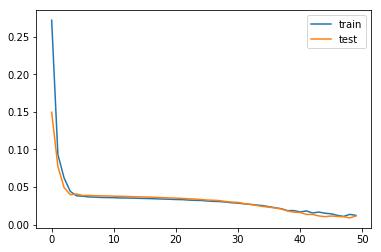

In [100]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## LSTM Multiple Layers

In [14]:
nfeat = len(train_clean_df[neighbor_stations_90].columns)
nlags = 2
nsteps = 1
reshaped_df = series_to_supervised(train_clean_df[neighbor_stations_90], n_in=nlags, n_out=nsteps)

In [15]:
nobs = nlags * nfeat

In [16]:
train_X, train_Y = reshaped_df.iloc[:,:nobs].values, reshaped_df.iloc[:,-nfeat].values
train_X = train_X.reshape((train_X.shape[0], nlags, nfeat))

In [17]:
val_reshaped_df = series_to_supervised(validation_clean_df[neighbor_stations_90], n_in=nlags, n_out=nsteps)
validation_X, validation_Y = val_reshaped_df.iloc[:,:nobs].values, val_reshaped_df.iloc[:,-nfeat].values
validation_X = validation_X.reshape((validation_X.shape[0], nlags, nfeat))

In [18]:
neurons = 50

In [43]:
# design network
model = Sequential()
model.add(LSTM(neurons, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
model.add(LSTM(neurons, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
model.add(LSTM(neurons, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2]), kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_Y, epochs=50, batch_size=72, validation_data=(validation_X, validation_Y), verbose=0, shuffle=False)

In [44]:
yhat = model.predict(validation_X)

In [45]:
math.sqrt(mean_squared_error(validation_Y, yhat))

0.027720579041285703

In [28]:
len(yhat)

425

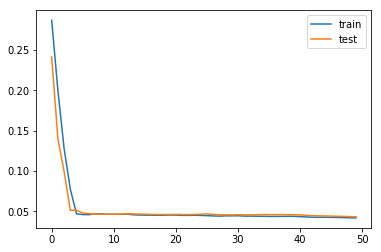

In [23]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Multi Layer Perceptron 

In [109]:
nfeat = len(train_clean_df[neighbor_stations_90].columns)
nlags = 2
nsteps = 1
neurons = 50

train_reshaped_df = series_to_supervised(train_clean_df[neighbor_stations_90], n_in=nlags, n_out=nsteps)
train_X, train_Y = train_reshaped_df.iloc[:,:nobs].values, train_reshaped_df.iloc[:,-nfeat].values

val_reshaped_df = series_to_supervised(validation_clean_df[neighbor_stations_90], n_in=nlags, n_out=nsteps)
validation_X, validation_Y = val_reshaped_df.iloc[:,:nobs].values, val_reshaped_df.iloc[:,-nfeat].values

In [110]:
# design network
model = Sequential()
model.add(Dense(neurons, activation='relu', input_dim=train_X.shape[1]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_Y, epochs=50, batch_size=72, verbose=True, shuffle=False)

Epoch 1/50
852/852 [==============================] - 10s 11ms/step - loss: 0.0101
Epoch 2/50
852/852 [==============================] - 0s 35us/step - loss: 0.0025
Epoch 3/50
852/852 [==============================] - 0s 35us/step - loss: 0.0018
Epoch 4/50
852/852 [==============================] - 0s 35us/step - loss: 0.0014
Epoch 5/50
852/852 [==============================] - 0s 34us/step - loss: 0.0013
Epoch 6/50
852/852 [==============================] - 0s 34us/step - loss: 0.0012
Epoch 7/50
852/852 [==============================] - 0s 35us/step - loss: 0.0011
Epoch 8/50
852/852 [==============================] - 0s 35us/step - loss: 0.0011
Epoch 9/50
852/852 [==============================] - 0s 36us/step - loss: 0.0010
Epoch 10/50
852/852 [==============================] - 0s 35us/step - loss: 9.5929e-04
Epoch 11/50
852/852 [==============================] - 0s 32us/step - loss: 8.9954e-04
Epoch 12/50
852/852 [==============================] - 0s 36us/step - loss: 8.4042e-04


In [111]:
yhat = model.predict(validation_X)

KeyError: 'val_loss'

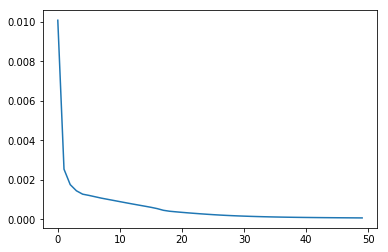

In [112]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()